# Exploratory Data Analysis - Senior Center Provider Data
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import geopandas as gpd
from senior_center_fy2020_data import scpd

In [2]:
scpd.columns

Index(['DFTA ID', 'Senior Center Name', 'Site Type', 'Borough',
       'Contract From Date', 'Contract To Date', 'Total FTEs', 'Total PTEs',
       'Months in HHS', 'Total Budget', 'Total Personnel Budget',
       'Total Expenses', 'Average Daily Clients', 'Kosher Meal Budget',
       'Non-Kosher Meal Budget', 'Total Meal Budget',
       'Average Meal Expenditure Per Client', 'Meal Prep Type',
       'Meal Prep For Other Centers', 'Total AIB-SCE-HPP Expenditures',
       'Average AIB-SCE-HPP Expenditures Per Client', 'Percent Utilization',
       'Latitude', 'Longitude', 'Total Employees', 'Client to Staff Ratio',
       'PTE Status', '% Budget Allocated for Personnel',
       '% Budget Allocated for Meals',
       '% Budget Used for AIB, SCE, & HPP Services'],
      dtype='object')

---
# Understanding the variables

## What are my grouping/categorical columns:
* `Site Type` (program site type: Neighborhood Senior Centers, Innovative Senior Centers, Senior Center)
* `Borough` (Brooklyn, Manhattan, Bronx, Queens, Staten Island)
* `Meal Prep Type` (program prepares meal in-house: Meal Prep On-Site, Catered, Both, Not Applicable)
* `Meal Prep For Other Centers` (program prepares meals for other sites: No, Yes)
* `PTE Status` (part-time employees: No PTEs, Has PTEs)

In [3]:
# Get the sample size (n) for each grouping variable
for col in ['Site Type', 'Borough', 'Meal Prep Type', 'Meal Prep For Other Centers', 'PTE Status']:
    print(f'{scpd.value_counts(col)}\n')

Site Type
Neighborhood Senior Centers    271
Innovative Senior Centers       18
Senior Center                    5
dtype: int64

Borough
Brooklyn         97
Manhattan        73
Bronx            56
Queens           56
Staten Island    12
dtype: int64

Meal Prep Type
Meal Prep On-Site    149
Catered              101
Not Applicable        31
Both                  13
dtype: int64

Meal Prep For Other Centers
No     250
Yes     44
dtype: int64

PTE Status
Has PTEs       149
Has No PTEs    145
dtype: int64



---
# Generating a quick-and-dirty correlation matrix to see what numerical variables might be related

In [4]:
numeric_cols = ['Total Employees', 'Total FTEs', 'Total PTEs', 'Client to Staff Ratio', 'Total Budget', 'Total Personnel Budget', 'Total Meal Budget',
                '% Budget Allocated for Personnel', '% Budget Allocated for Meals', '% Budget Used for AIB, SCE, & HPP Services',
                'Average Daily Clients', 'Total Expenses', 'Total AIB-SCE-HPP Expenditures', 'Average Meal Expenditure Per Client',
                'Average AIB-SCE-HPP Expenditures Per Client']

# Compute a correlation matrix and assign to corr_matrix
corr_matrix = scpd[numeric_cols].corr('pearson')

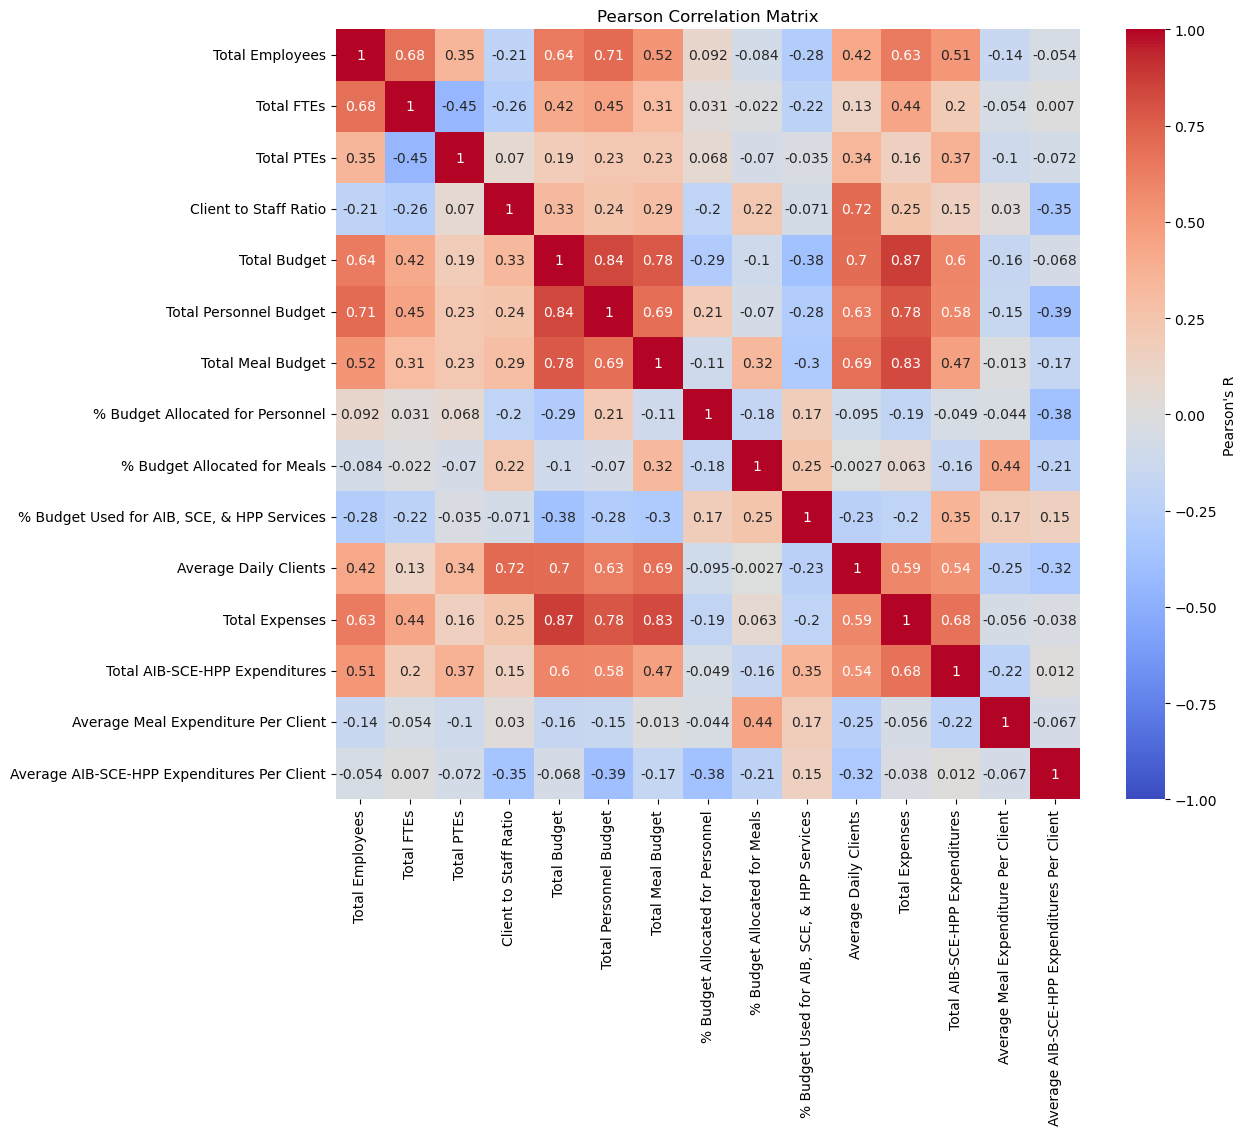

In [5]:
# Plot a heatmap from corr_matrix
plt.figure(figsize = (12, 10))

sns.heatmap(corr_matrix, vmin = -1.0, vmax = 1.0, annot = True, cmap = 'coolwarm',
            cbar_kws = {
                'label': 'Pearson\'s R',
                'orientation': 'vertical'
            }).set(title = 'Pearson Correlation Matrix')

plt.show()

## Potential relationships to explore
About total budget:
* `Total Budget` x `Total Employees` (r = 0.64)
* `Total Budget` x `Total Meal Budget` (r = 0.78)

About total personnel budget:
* `Total Personnel Budget` x `Total Budget` (r = 0.84)
* `Total Personnel Budget` x `Total Employees` (r = 0.71)
* `Total Personnel Budget` x `Total Meal Budget` (r = 0.69)

About average daily clients:
* `Average Daily Clients` x `Total Employees` (r = 0.42)
* `Average Daily Clients` x `Total Budget` (r = 0.7)
* `Average Daily Clients` x `Total Personnel Budget` (r = 0.63)
* `Average Daily Clients` x `Total Meal Budget` (r = 0.69)
* `Average Daily Clients` x `Total Expenses` (r = 0.59)
* `Average Daily Clients` x `Client to Staff Ratio` (r = 0.72)

About total expenses:
* `Total Expenses` x `Total Employees` (r = 0.63)
* `Total Expenses` x `Total Budget` (r = 0.87)
* `Total Expenses` x `Total Personnel Budget` (r = 0.78)
* `Total Expenses` x `Total Meal Budget` (r = 0.83)
* `Total Expenses` x `Total AIB-SCE-HPP Expenditures` (r = 0.68)

About meals:
* `Average Meal Expenditure Per Client` x `% Budget Allocated for Meals` (r = 0.44)

---
# Grouping by Borough

## How many senior centers partnered with NYC Aging are in each borough?

In [6]:
sc_counts = scpd.value_counts('Borough')
print(f"The number of senior centers in each borough is:\n{sc_counts}")

The number of senior centers in each borough is:
Borough
Brooklyn         97
Manhattan        73
Bronx            56
Queens           56
Staten Island    12
dtype: int64


## What is the mean & median number of employees (FTEs + PTEs) per senior center for each borough?

In [7]:
scpd.groupby('Borough')['Total Employees'].describe()[['mean', 'std', '50%']]

,mean,std,50%
Borough,,,
Bronx,8.178571,3.247976,8.0
Brooklyn,9.030928,4.590419,8.0
Manhattan,10.000000,4.493823,10.0
Queens,10.660714,5.254528,9.0
Staten Island,12.833333,5.024184,12.0


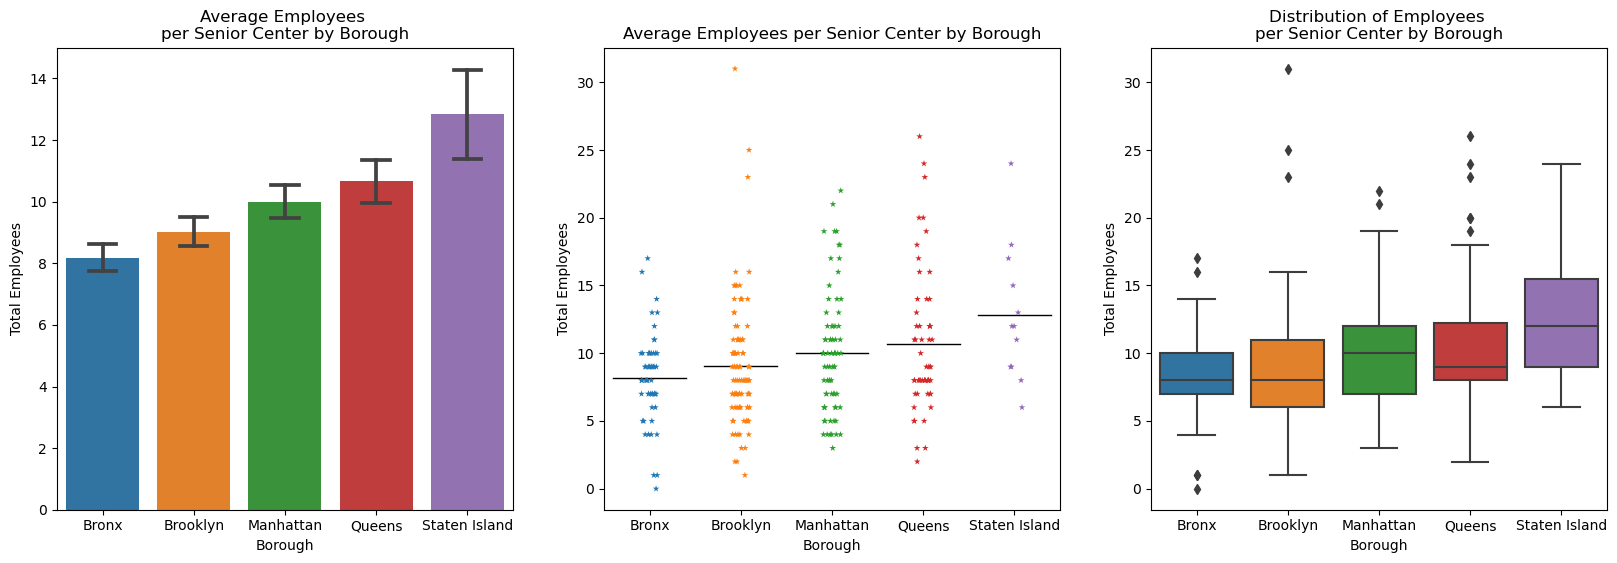

In [8]:
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.barplot(scpd, x = 'Borough', y = 'Total Employees', errorbar = 'se', capsize = .3).set(title = 'Average Employees \nper Senior Center by Borough')

plt.subplot(1, 3, 2)
sns.stripplot(scpd, x = 'Borough', y = 'Total Employees', hue = 'Borough', marker = '*', jitter = True, legend = False).set(title = 'Average Employees per Senior Center by Borough')
sns.boxplot(scpd, x = 'Borough', y = 'Total Employees', showmeans = True, meanline = True,
           meanprops = {'color': 'k', 'ls': '-', 'lw': 1}, medianprops = {'visible': False}, whiskerprops = {'visible': False},
           showbox = False, showcaps = False, showfliers = False)

plt.subplot(1, 3, 3)
sns.boxplot(scpd, x = 'Borough', y = 'Total Employees').set(title = 'Distribution of Employees \nper Senior Center by Borough')

plt.show()

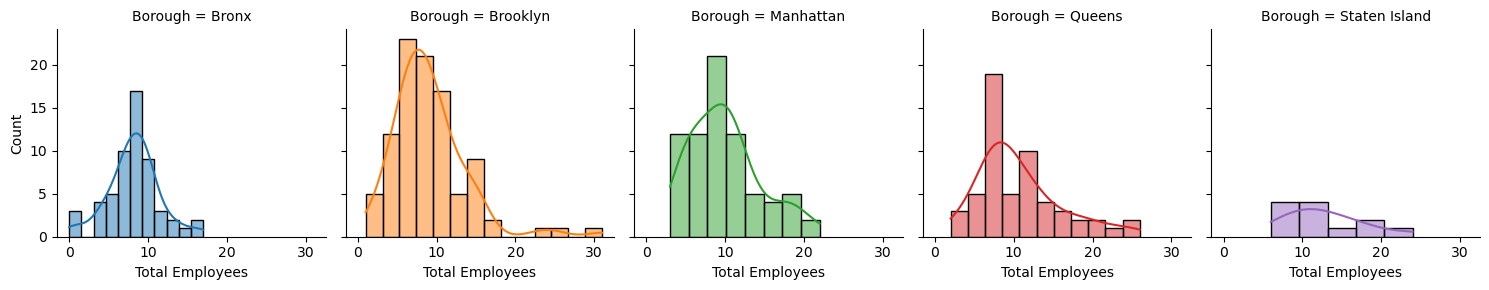

In [9]:
boroughs_facetgrid = sns.FacetGrid(scpd, col = 'Borough', hue = 'Borough')
boroughs_facetgrid.map(sns.histplot, 'Total Employees', kde = True)
plt.show()

## What is the mean & median Client to Staff Ratio for each borough?

In [10]:
scpd[~np.isinf(scpd['Client to Staff Ratio'])].groupby('Borough')['Client to Staff Ratio'].describe()[['mean', 'std', '50%']]

,mean,std,50%
Borough,,,
Bronx,8.528455,3.640804,7.857143
Brooklyn,9.149819,5.727363,7.090909
Manhattan,9.512329,4.812916,8.388889
Queens,9.362439,6.005119,8.000000
Staten Island,4.872222,2.277690,5.000000


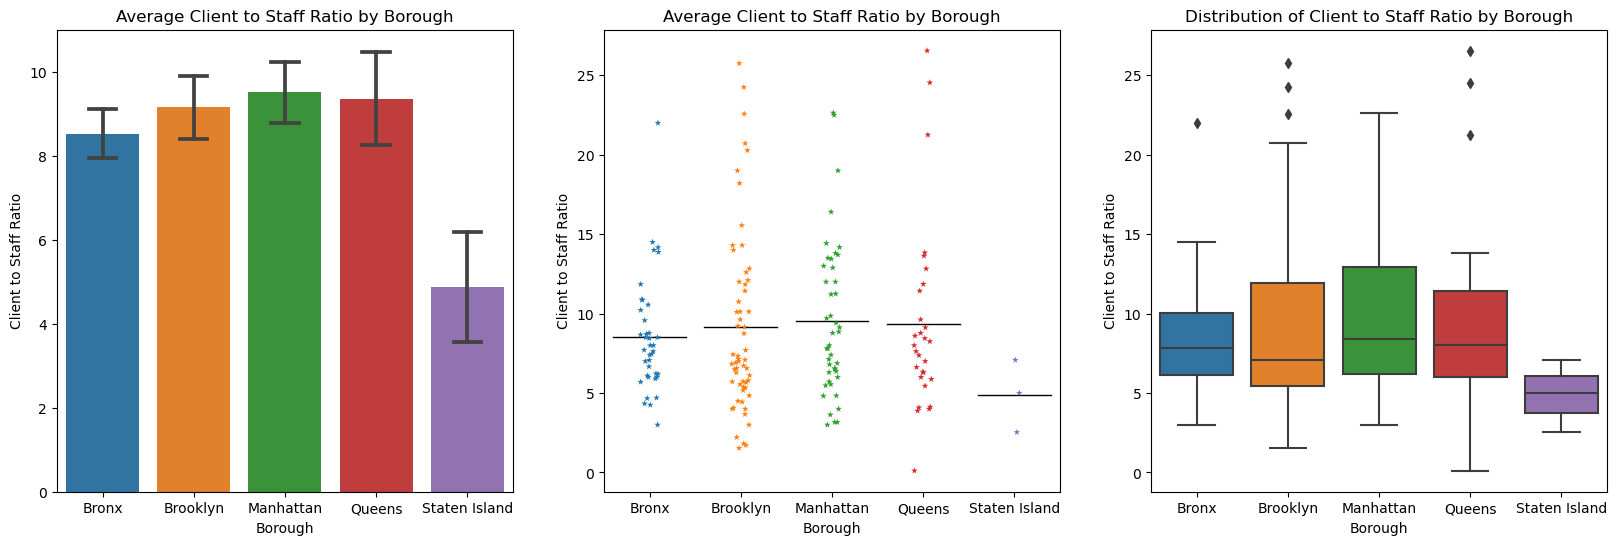

In [11]:
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.barplot(scpd[~np.isinf(scpd['Client to Staff Ratio'])], x = 'Borough', y = 'Client to Staff Ratio', errorbar = 'se', capsize = .3).set(title = 'Average Client to Staff Ratio by Borough')

plt.subplot(1, 3, 2)
sns.stripplot(scpd[~np.isinf(scpd['Client to Staff Ratio'])], x = 'Borough', y = 'Client to Staff Ratio', hue = 'Borough', marker = '*', jitter = True, legend = False).set(title = 'Average Client to Staff Ratio by Borough')
sns.boxplot(scpd[~np.isinf(scpd['Client to Staff Ratio'])], x = 'Borough', y = 'Client to Staff Ratio', showmeans = True, meanline = True,
           meanprops = {'color': 'k', 'ls': '-', 'lw': 1}, medianprops = {'visible': False}, whiskerprops = {'visible': False},
           showbox = False, showcaps = False, showfliers = False)

plt.subplot(1, 3, 3)
sns.boxplot(scpd[~np.isinf(scpd['Client to Staff Ratio'])], x = 'Borough', y = 'Client to Staff Ratio').set(title = 'Distribution of Client to Staff Ratio by Borough')

plt.show()

## How many senior centers have part-time employees (PTEs) in addition to FTEs in each borough?

In [12]:
pte_df = scpd.groupby(['Borough', 'PTE Status'])['Total PTEs'].count()

print(f"For each borough, the number of senior centers having vs. not having PTEs is: \n\n{pte_df}")

For each borough, the number of senior centers having vs. not having PTEs is: 

Borough        PTE Status 
Bronx          Has No PTEs    33
               Has PTEs       23
Brooklyn       Has No PTEs    54
               Has PTEs       43
Manhattan      Has No PTEs    26
               Has PTEs       47
Queens         Has No PTEs    30
               Has PTEs       26
Staten Island  Has No PTEs     2
               Has PTEs       10
Name: Total PTEs, dtype: int64


In [13]:
# What percentage of senior centers by borough have part-time employees?
sc_with_ptes_counts = pte_df[pd.IndexSlice[:, 'Has PTEs']]
percent_sc_with_ptes = (sc_with_ptes_counts / sc_counts) * 100

percent_sc_with_ptes

Borough
Bronx            41.071429
Brooklyn         44.329897
Manhattan        64.383562
Queens           46.428571
Staten Island    83.333333
dtype: float64

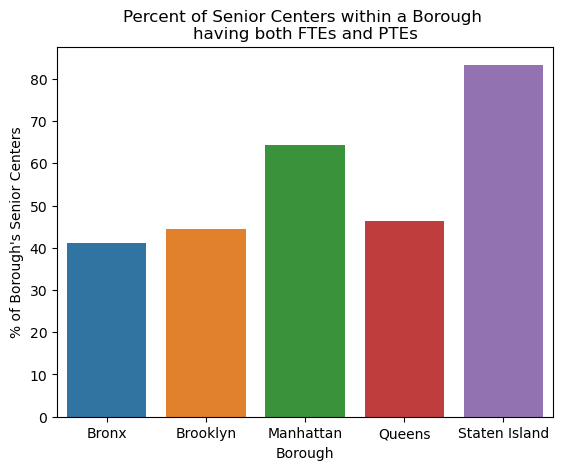

In [14]:
sns.barplot(x = percent_sc_with_ptes.index, y = percent_sc_with_ptes.values).set(title = 'Percent of Senior Centers within a Borough \nhaving both FTEs and PTEs', ylabel = '% of Borough\'s Senior Centers')
plt.show()

## What is the average number of full-time employees vs. part-time employees for each borough?

In [15]:
print('Average & Median Full-Time Employees by Borough')
avg_ftes = scpd.groupby('Borough')['Total FTEs'].describe()[['mean', 'std', '50%']]
avg_ftes

Average & Median Full-Time Employees by Borough


,mean,std,50%
Borough,,,
Bronx,5.946429,3.839601,7.0
Brooklyn,7.134021,4.738207,7.0
Manhattan,6.095890,4.705683,6.0
Queens,8.071429,5.761493,8.0
Staten Island,7.166667,4.745013,8.0


In [16]:
print('Average & Median Part-Time Employees by Borough')
avg_ptes = scpd.groupby('Borough')['Total PTEs'].describe()[['mean', 'std', '50%']]
avg_ptes

Average & Median Part-Time Employees by Borough


,mean,std,50%
Borough,,,
Bronx,2.232143,3.516150,0.0
Brooklyn,1.896907,2.855859,0.0
Manhattan,3.904110,4.435226,2.0
Queens,2.589286,3.711294,0.0
Staten Island,5.666667,4.478907,4.5


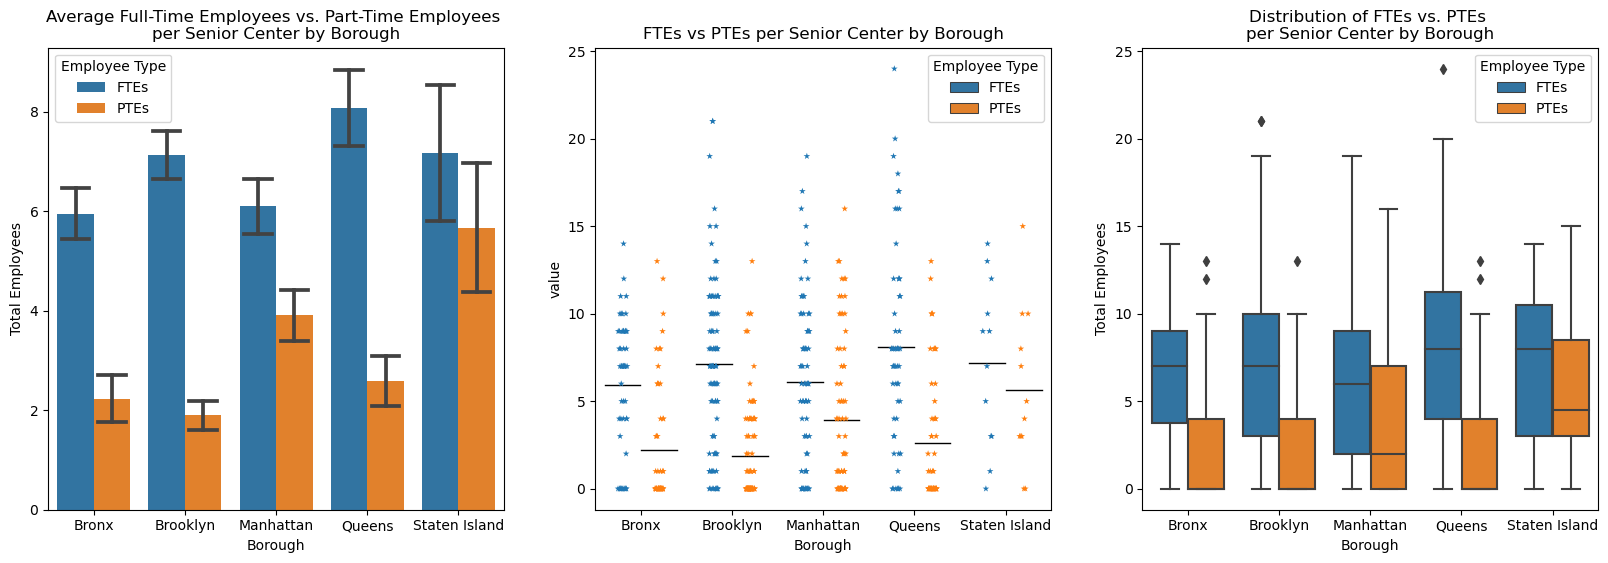

In [17]:
# Declare melted_df dataframe that reshapes data so 'Total FTEs' and 'Total PTEs' are combined into a single 'value' column
melted_df = scpd.melt(id_vars = 'Borough', value_vars = ['Total FTEs', 'Total PTEs'], var_name = 'Employee Type')
melted_df['Employee Type'] = melted_df['Employee Type'].replace({'Total FTEs': 'FTEs', 'Total PTEs': 'PTEs'})

# Create figure
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.barplot(melted_df, x = 'Borough', y = 'value', hue = 'Employee Type', errorbar = 'se', capsize = 0.3).set(title = 'Average Full-Time Employees vs. Part-Time Employees \nper Senior Center by Borough', ylabel = 'Total Employees')

plt.subplot(1, 3, 2)
sns.stripplot(melted_df, x = 'Borough', y = 'value', hue = 'Employee Type', marker = '*', jitter = True, dodge = True, legend = False).set(title = 'FTEs vs PTEs per Senior Center by Borough', ylabel = 'Total Employees')
sns.boxplot(melted_df, x = 'Borough', y = 'value', hue = 'Employee Type', showmeans = True, meanline = True,
           meanprops = {'color': 'k', 'ls': '-', 'lw': 1}, medianprops = {'visible': False}, whiskerprops={'visible': False},
           showbox = False, showcaps = False, showfliers = False)

plt.subplot(1, 3, 3)
sns.boxplot(melted_df, x = 'Borough', y = 'value', hue = 'Employee Type').set(title = 'Distribution of FTEs vs. PTEs \nper Senior Center by Borough', ylabel = 'Total Employees')
plt.show()

## What is the mean & median number of daily clients by borough?

In [18]:
scpd.groupby('Borough')['Average Daily Clients'].describe()[['mean', 'std', '50%']]

,mean,std,50%
Borough,,,
Bronx,67.333333,26.229085,62.0
Brooklyn,78.118644,45.098010,72.0
Manhattan,98.727273,61.606162,85.0
Queens,101.862069,81.254329,77.0
Staten Island,69.333333,27.135463,85.0


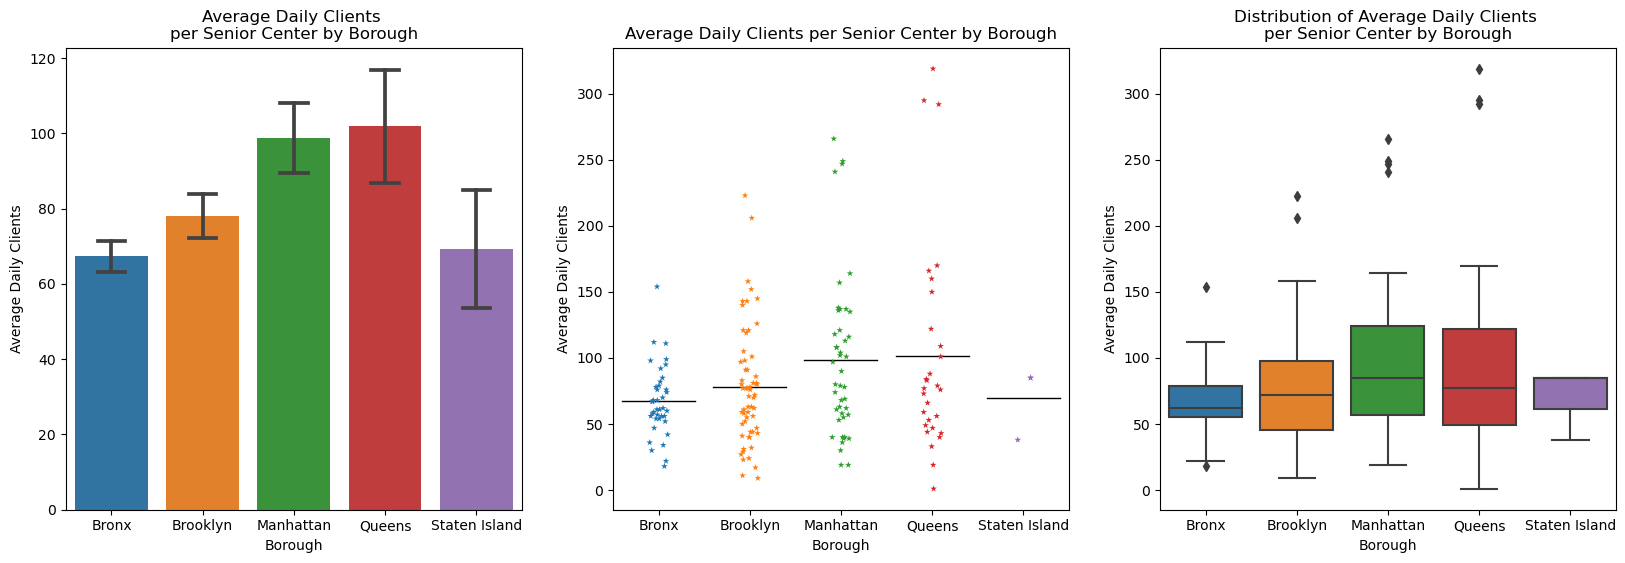

In [19]:
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.barplot(scpd, x = 'Borough', y = 'Average Daily Clients', errorbar = 'se', capsize = .3).set(title = 'Average Daily Clients \nper Senior Center by Borough')

plt.subplot(1, 3, 2)
sns.stripplot(scpd, x = 'Borough', y = 'Average Daily Clients', hue = 'Borough', marker = '*', jitter = True, legend = False).set(title = 'Average Daily Clients per Senior Center by Borough')
sns.boxplot(scpd, x = 'Borough', y = 'Average Daily Clients', showmeans = True, meanline = True,
           meanprops = {'color': 'k', 'ls': '-', 'lw': 1}, medianprops = {'visible': False}, whiskerprops = {'visible': False},
           showbox = False, showcaps = False, showfliers = False)

plt.subplot(1, 3, 3)
sns.boxplot(scpd, x = 'Borough', y = 'Average Daily Clients').set(title = 'Distribution of Average Daily Clients \nper Senior Center by Borough')

plt.show()

## Is there a relationship between total number of employees and average daily clients (by borough)?

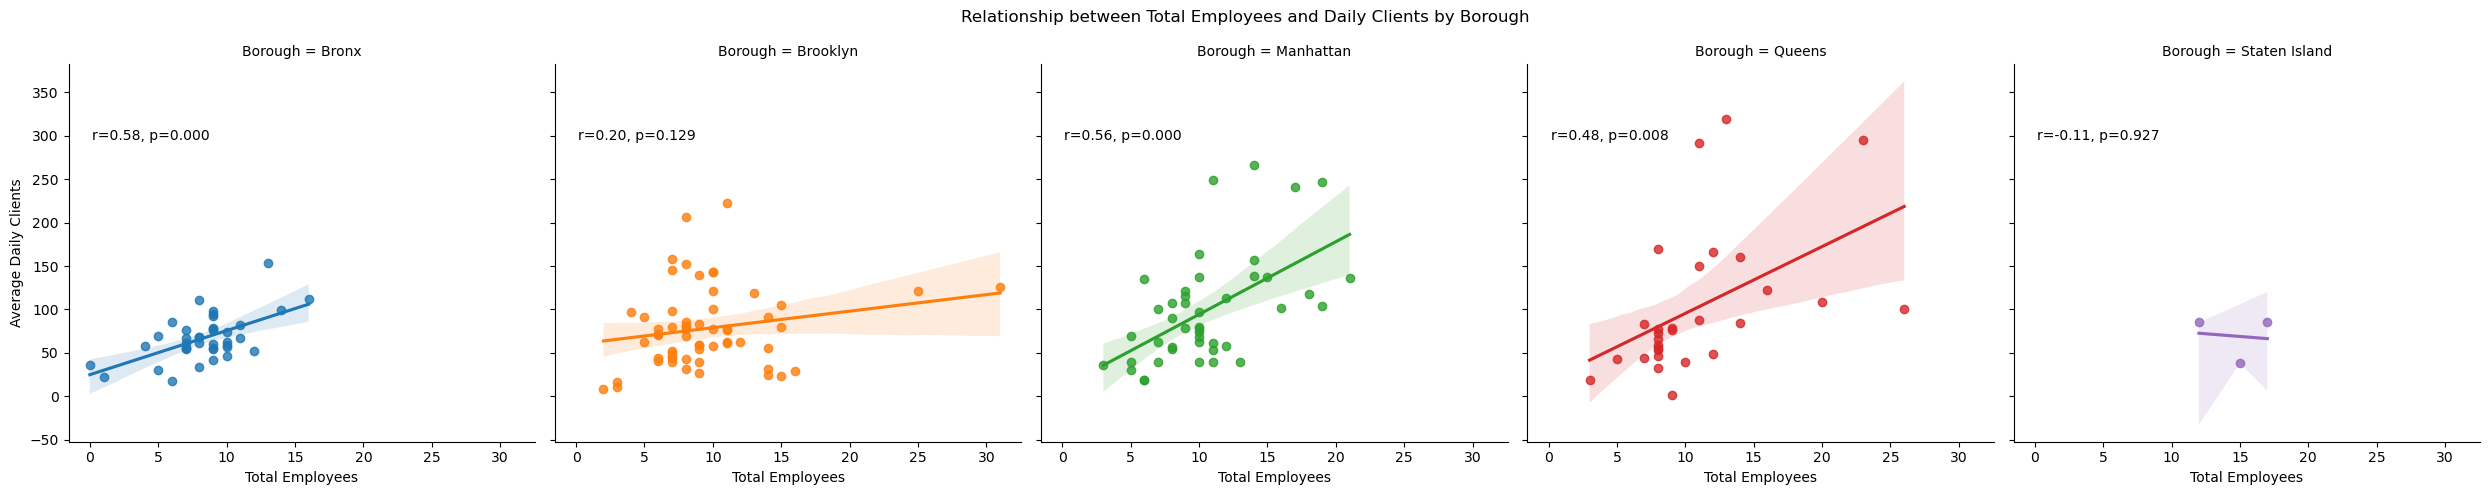

In [20]:
# Declare a FacetGrid boroughs_facetgrid containing plots of linear regressions by borough
boroughs_facetgrid = sns.lmplot(scpd, x = 'Total Employees', y = 'Average Daily Clients', col = 'Borough', hue = 'Borough')
boroughs_facetgrid.fig.suptitle("Relationship between Total Employees and Daily Clients by Borough")

# Define a function annotate that gets the current plot in the grid and annotates the pearson r and p-value onto the plot
def annotate(data, x, y, **kws):
    bool_mask = (data[x].notna()) & (data[y].notna())
    r, p = pearsonr(data.loc[bool_mask, x], data.loc[bool_mask, y])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.3f}'.format(r, p), transform = ax.transAxes)

# Plot the pearson-r values and p-values
boroughs_facetgrid.map_dataframe(annotate, x = 'Total Employees', y = 'Average Daily Clients')

plt.show()

## Is there a relationship between client to staff ratio and average daily clients (by borough)?

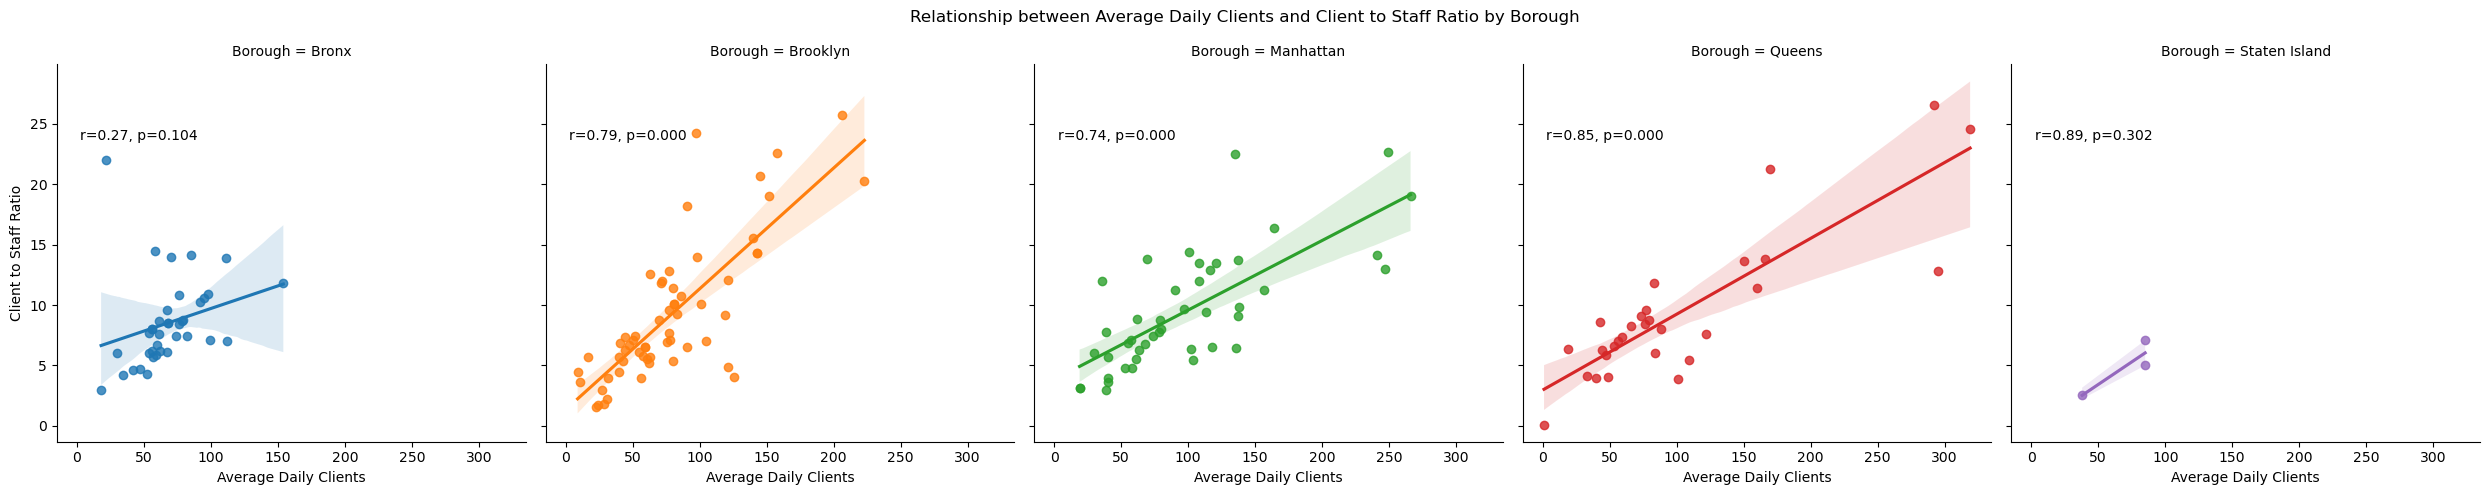

In [21]:
boroughs_facetgrid = sns.lmplot(scpd[~np.isinf(scpd['Client to Staff Ratio'])], x = 'Average Daily Clients', y = 'Client to Staff Ratio', col = 'Borough', hue = 'Borough')
boroughs_facetgrid.fig.suptitle("Relationship between Average Daily Clients and Client to Staff Ratio by Borough")
boroughs_facetgrid.map_dataframe(annotate, x = 'Average Daily Clients', y = 'Client to Staff Ratio')

plt.show()

## Is there a relationship between total number of employees and total budget for the year (by borough)?

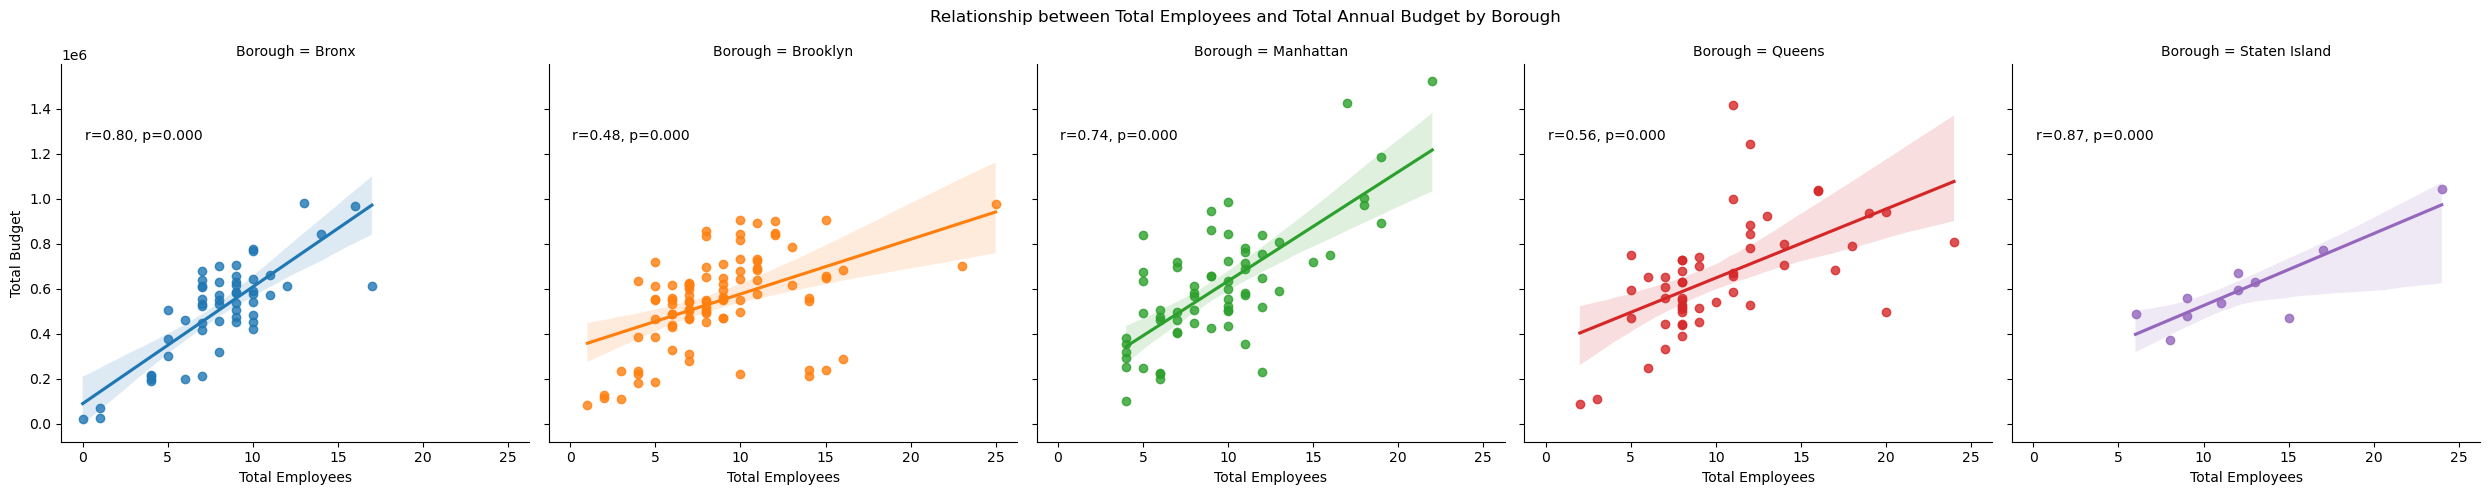

In [22]:
boroughs_facetgrid = sns.lmplot(scpd, x = 'Total Employees', y = 'Total Budget', col = 'Borough', hue = 'Borough')
boroughs_facetgrid.fig.suptitle("Relationship between Total Employees and Total Annual Budget by Borough")
boroughs_facetgrid.map_dataframe(annotate, x = 'Total Employees', y = 'Total Budget')

plt.show()

## Is there a relationship between total number of employees and total personnel budget (by borough)?

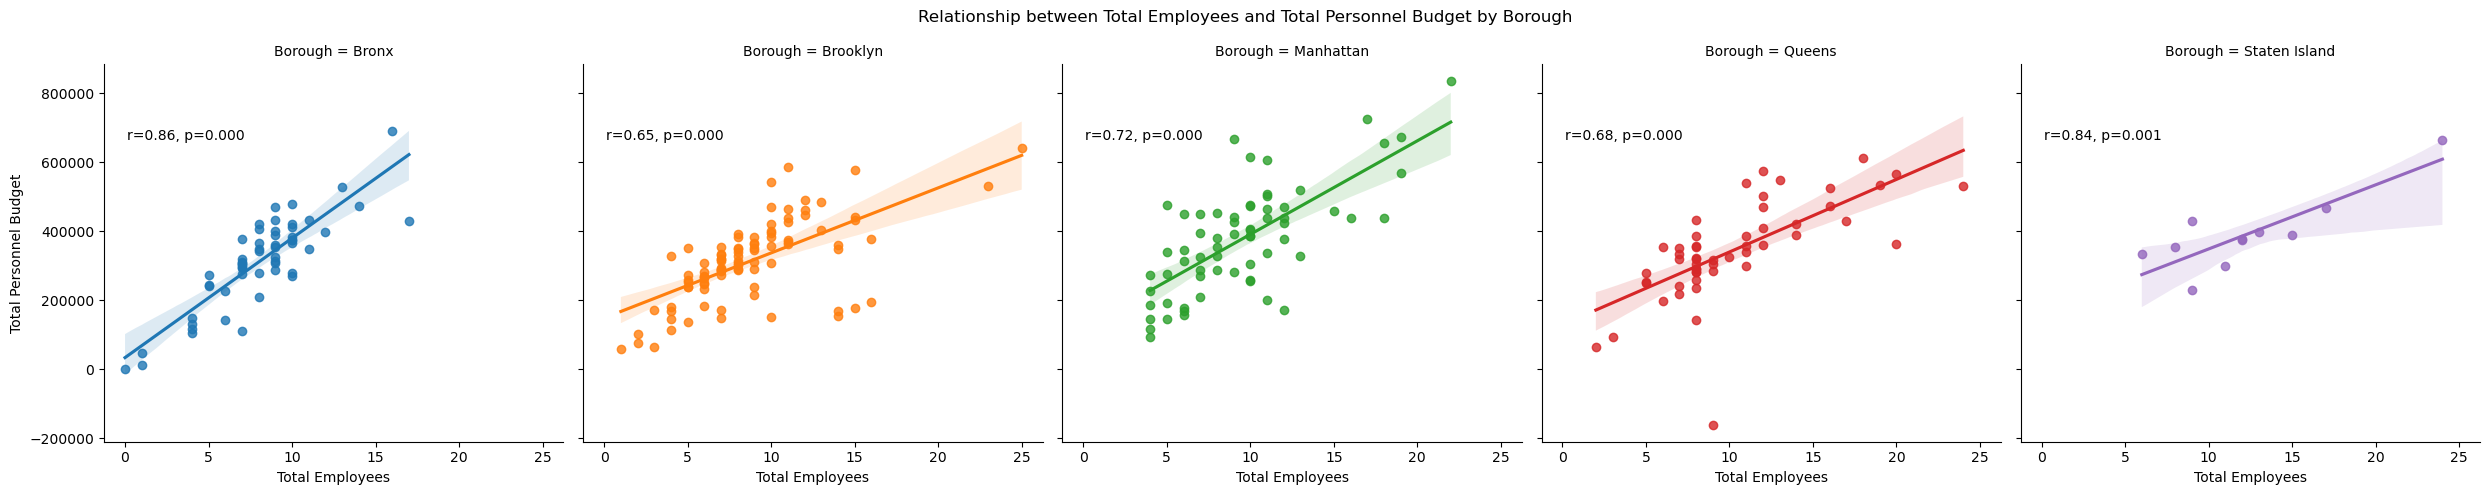

In [23]:
boroughs_facetgrid = sns.lmplot(scpd, x = 'Total Employees', y = 'Total Personnel Budget', col = 'Borough', hue = 'Borough')
boroughs_facetgrid.fig.suptitle("Relationship between Total Employees and Total Personnel Budget by Borough")
boroughs_facetgrid.map_dataframe(annotate, x = 'Total Employees', y = 'Total Personnel Budget')

plt.show()

## Is there a relationship between average daily clients and total meal budget (by borough)?

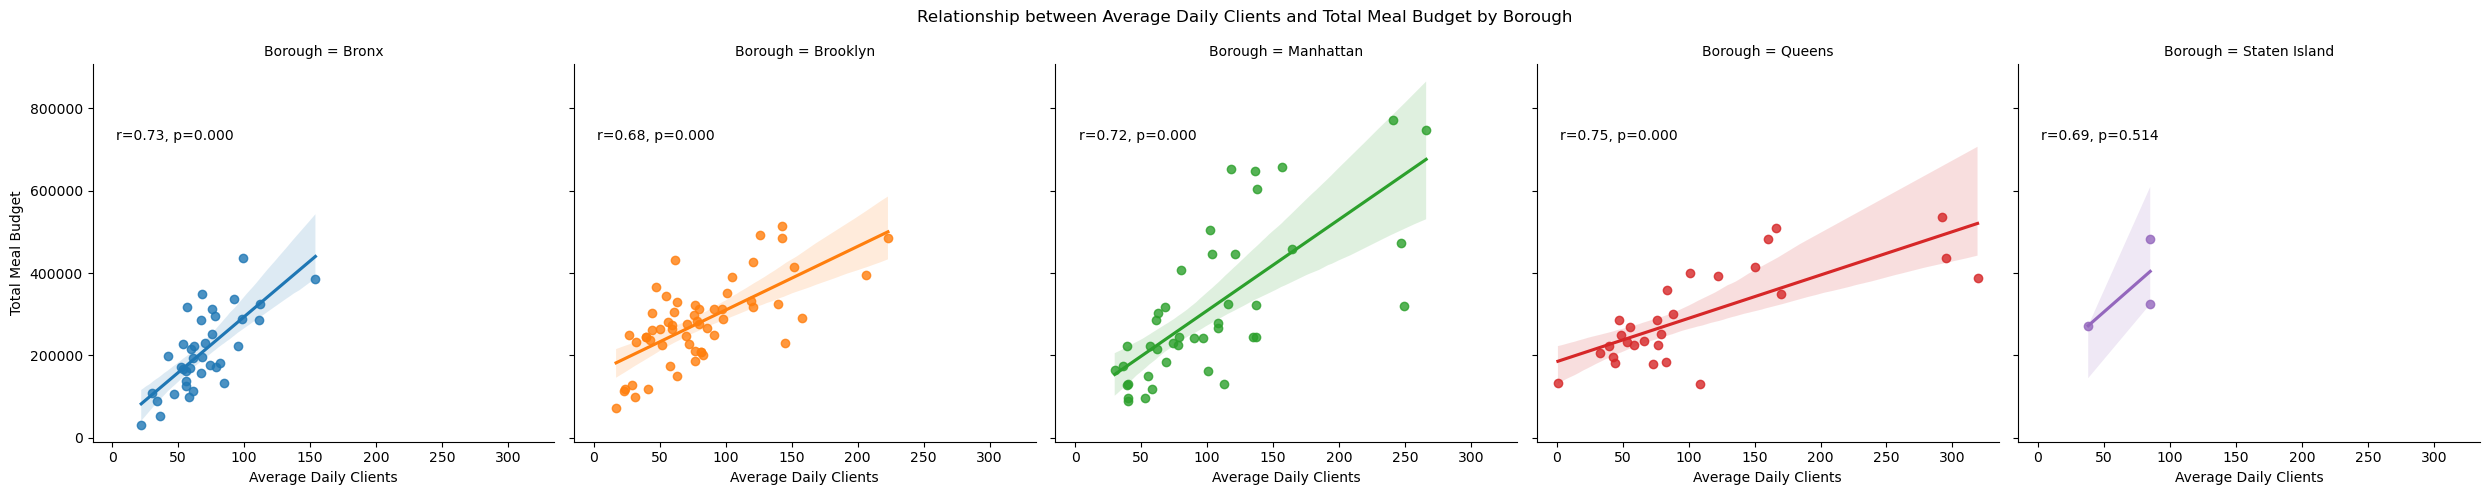

In [24]:
boroughs_facetgrid = sns.lmplot(scpd, x = 'Average Daily Clients', y = 'Total Meal Budget', col = 'Borough', hue = 'Borough')
boroughs_facetgrid.fig.suptitle("Relationship between Average Daily Clients and Total Meal Budget by Borough")
boroughs_facetgrid.map_dataframe(annotate, x = 'Average Daily Clients', y = 'Total Meal Budget')

plt.show()

## What is the mean & median total expenses for each borough?

In [25]:
scpd.groupby('Borough')['Total Expenses'].describe()[['mean', 'std', '50%']]

,mean,std,50%
Borough,,,
Bronx,369120.039091,199311.078959,384695.170
Brooklyn,433554.731398,175878.766306,446247.860
Manhattan,470807.224154,255612.760306,477185.590
Queens,528846.411923,203364.585443,510450.885
Staten Island,491657.928182,147705.046846,490465.470


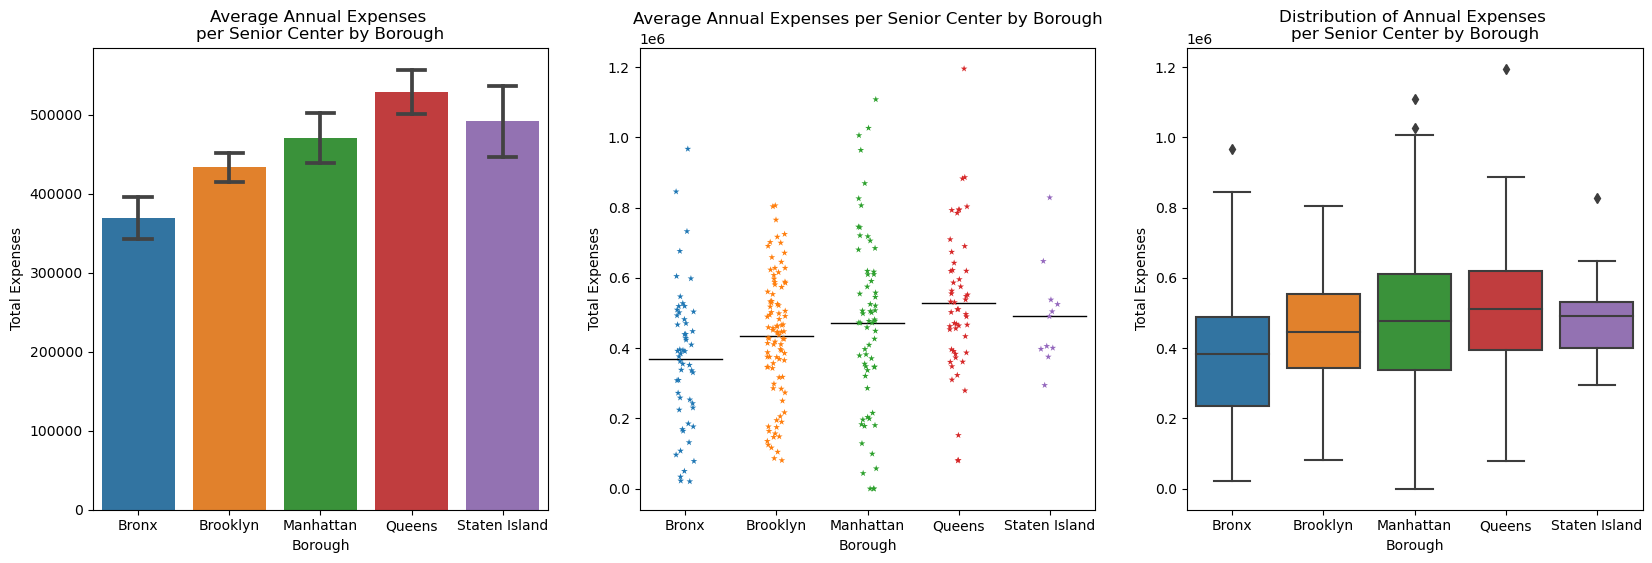

In [26]:
plt.figure(figsize = (20, 6))

plt.subplot(1, 3, 1)
sns.barplot(scpd, x = 'Borough', y = 'Total Expenses', errorbar = 'se', capsize = .3).set(title = 'Average Annual Expenses \nper Senior Center by Borough')

plt.subplot(1, 3, 2)
sns.stripplot(scpd, x = 'Borough', y = 'Total Expenses', hue = 'Borough', marker = '*', jitter = True, legend = False).set(title = 'Average Annual Expenses per Senior Center by Borough')
sns.boxplot(scpd, x = 'Borough', y = 'Total Expenses', showmeans = True, meanline = True,
           meanprops = {'color': 'k', 'ls': '-', 'lw': 1}, medianprops = {'visible': False}, whiskerprops = {'visible': False},
           showbox = False, showcaps = False, showfliers = False)

plt.subplot(1, 3, 3)
sns.boxplot(scpd, x = 'Borough', y = 'Total Expenses').set(title = 'Distribution of Annual Expenses \nper Senior Center by Borough')

plt.show()

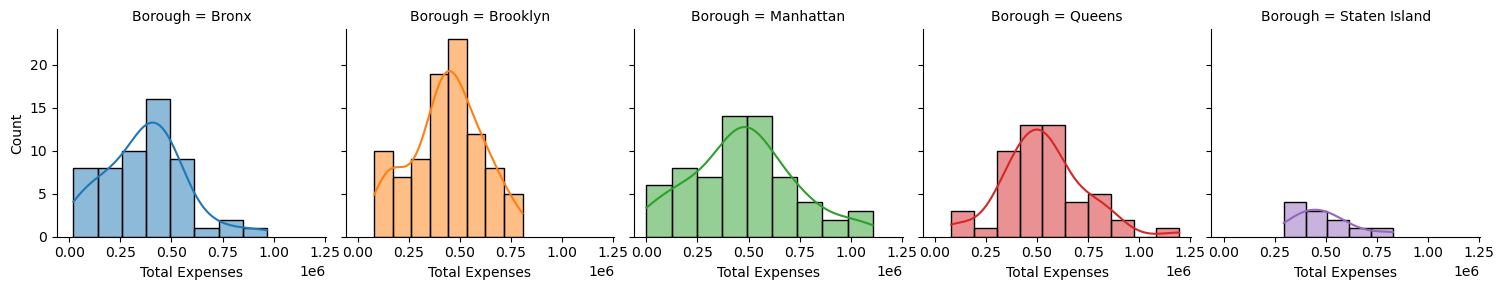

In [27]:
boroughs_facetgrid = sns.FacetGrid(scpd, col = 'Borough', hue = 'Borough')
boroughs_facetgrid.map(sns.histplot, 'Total Expenses', kde = True)
plt.show()

## What is the mean & median percent budget allocated for meals in each borough?

In [28]:
scpd.groupby('Borough')['% Budget Allocated for Meals'].describe()[['mean', 'std', '50%']]

,mean,std,50%
Borough,,,
Bronx,0.449006,0.350359,0.380692
Brooklyn,0.452983,0.103599,0.463369
Manhattan,0.434883,0.157186,0.427318
Queens,0.409576,0.151333,0.424667
Staten Island,0.477451,0.114621,0.477981


## What is the mean & median percent budget allocated for personnel in each borough?

In [29]:
scpd.groupby('Borough')['% Budget Allocated for Personnel'].describe()[['mean', 'std', '50%']]

,mean,std,50%
Borough,,,
Bronx,0.609888,0.127937,0.637253
Brooklyn,0.590367,0.105637,0.589625
Manhattan,0.636221,0.122903,0.628951
Queens,0.553821,0.168380,0.571826
Staten Island,0.667704,0.135904,0.632417


## What is the mean & median percent budget that was used for AIB, SCE, & HPP services in each borough?

In [30]:
scpd.groupby('Borough')['% Budget Used for AIB, SCE, & HPP Services'].describe()[['mean', 'std', '50%']]

,mean,std,50%
Borough,,,
Bronx,0.375603,0.214905,0.307496
Brooklyn,0.338853,0.150479,0.300810
Manhattan,0.380055,0.206659,0.335290
Queens,0.299374,0.102533,0.291190
Staten Island,0.320996,0.183265,0.280372


## What is the mean & median meal expenditure per client in each borough?

In [31]:
scpd.groupby('Borough')['Average Meal Expenditure Per Client'].describe()[['mean', 'std', '50%']]

,mean,std,50%
Borough,,,
Bronx,10.447736,10.616580,8.270
Brooklyn,9.777416,4.307099,8.900
Manhattan,9.272206,3.542537,8.885
Queens,9.984528,3.780151,9.650
Staten Island,9.673636,2.797403,9.820


---
# Creating GeoDataFrames

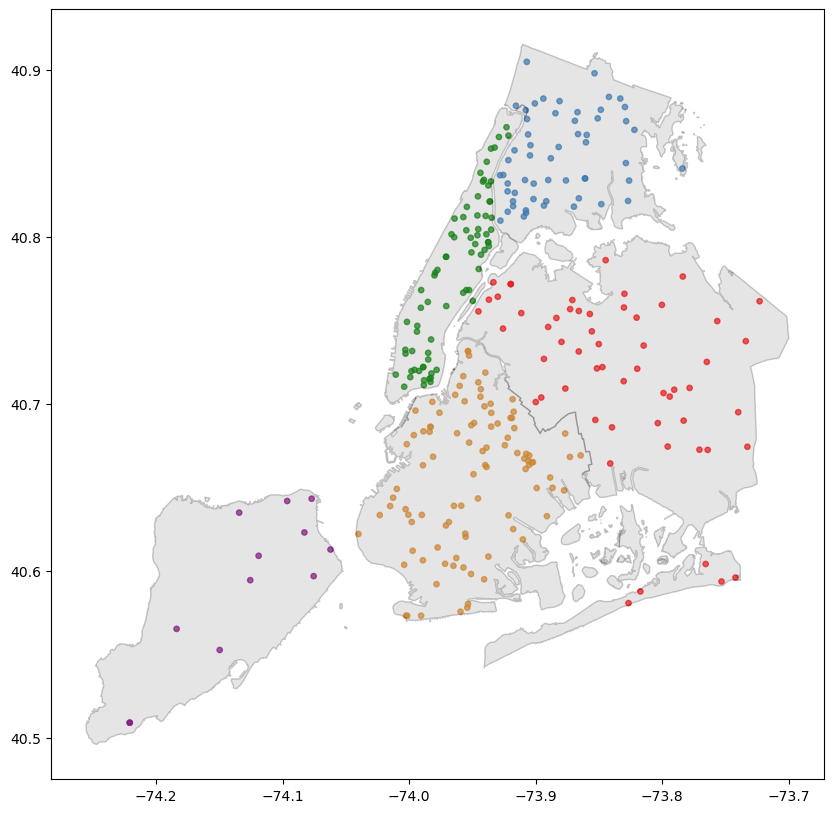

In [32]:
# Create color map dictionary for geodataframe markers
borough_cmap = {
    'Bronx': '#2F78BA',
    'Brooklyn': '#DE8821',
    'Manhattan': 'green',
    'Queens': 'red',
    'Staten Island': 'purple'
}

# Declare geodataframe (gdf) of points derived from latitude and longitude
gdf = gpd.GeoDataFrame(scpd, crs = 'EPSG:4326', geometry = gpd.points_from_xy(scpd['Longitude'], scpd['Latitude']))
gdf['color'] = gdf['Borough'].map(borough_cmap)
ax = gdf.plot(color = gdf['color'], figsize = (10, 10), markersize = 15, alpha = 0.7)

# Declare geodataframe (boroughs) of polygons derived from NYC OpenData Borough Boundaries shapefile
boroughs = gpd.read_file('borough_boundaries/geo_export_7aa9921d-9f8c-4d53-bf85-91dc1965edf9.shp')
boroughs.plot(ax = ax, alpha = 0.2, color = 'grey', edgecolor = 'black')

plt.show()